In [19]:
import numpy as np
from pyuvdata import UVData
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import glob
from uvtools import dspec
import copy

In [20]:
ddir = '../../param_sweep/'

In [21]:
ibl_files = glob.glob(ddir+'*ibl*uvh5')

In [22]:
ibl_files

['../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf200_df100.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf400_df100.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G15_nf200_df100.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf100_df200.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G15_nf100_df200.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf200_df200.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G15_nf200_df200.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf400_df200.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf100_df100.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5',
 '../../param_sweep/HERA-III

200 vs 400 channels.

In [23]:
def fft_arrange_wedge(uvd, tind=0, polind=0, window='bh', min_bl=0.1, filtermatrix=None, include_autos=False):
    """
    generate an (NF x NBL) array with baselines arranged in ascending length
    """
    uvd = copy.deepcopy(uvd)
    if not include_autos:
        uvd.select(bls=[bl for bl in uvd.get_antpairs() if bl[0] != bl[1]])
    data_inds = np.where(uvd.time_array == np.unique(uvd.time_array)[tind])[0]
    data = uvd.data_array[data_inds, 0, :, polind].reshape(len(data_inds), uvd.Nfreqs)
    if filtermatrix is not None:
        data = (filtermatrix @ (data.reshape(len(data_inds) * uvd.Nfreqs, order='F'))).reshape(len(data_inds), uvd.Nfreqs, order='F')
    bl_lens = np.linalg.norm(uvd.uvw_array[data_inds], axis=1)
    sorted_lens = np.argsort(bl_lens)
    data = data[sorted_lens, :]
    bl_lens = bl_lens[sorted_lens]
    data = data[bl_lens > min_bl]
    bl_lens = bl_lens[bl_lens > min_bl]
    wf = dspec.gen_window(window, uvd.Nfreqs)
    delays = 1e9 * np.fft.fftshift(np.fft.fftfreq(uvd.Nfreqs, np.mean(np.diff(uvd.freq_array))))
    return bl_lens, delays, np.fft.fftshift(np.fft.fft(np.fft.fftshift(wf[None, :] * data, axes=1), axis=1), axes=1)

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


95.40909090759112
49.72613065248466
27.056390977018292


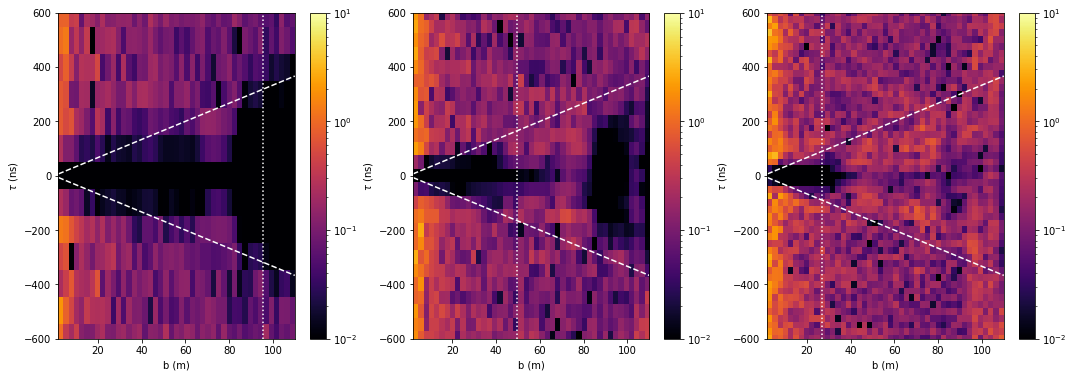

In [55]:

fnames = [f'../../param_sweep/HERA-III_dx2.0_rspace1_G10_nf{nf}_df100.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5' for nf in [100, 200, 400]]
fig, axarr = plt.subplots(1, len(fnames))
fig.set_size_inches(18, 6)
for i, fname in enumerate(fnames):
    uvd = UVData()
    uvd.read_uvh5(fname)
    plt.sca(axarr[i])
    x, y, ctot = fft_arrange_wedge(uvd, window='none')

    plt.imshow(np.abs(ctot).T, extent = [x.min(), x.max(), y.max(), y.min()],
               norm=LogNorm(1e-2, 1e1), interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')
    dx = np.abs(np.median(np.diff(uvd.uvw_array[:,0])))
    bw = uvd.freq_array.max() - uvd.freq_array.min()
    f0 = np.mean(uvd.freq_array)
    print(dx * f0 / bw)
    plt.axvline(dx * f0 / bw, ls=':', color='w')
    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    plt.ylim(-600, 600)

antenna_diameters is not set. Using known values for HERA.
antenna_diameters is not set. Using known values for HERA.


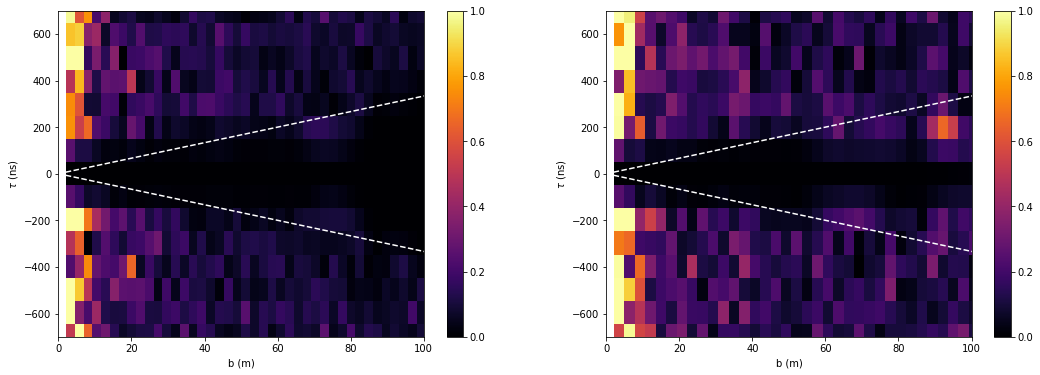

In [49]:

fnames = [f'../../param_sweep/HERA-III_dx2.0_rspace1_G{gorder}_nf{100}_df100.000kHz_f0100.000_bmult1.00_tol1.0e-11_ibl.uvh5' for gorder in [10, 15]]
fig, axarr = plt.subplots(1, len(fnames))
fig.set_size_inches(18, 6)
for i, fname in enumerate(fnames):
    uvd = UVData()
    uvd.read_uvh5(fname)
    plt.sca(axarr[i])
    x, y, ctot = fft_arrange_wedge(uvd, window='none')

    plt.imshow(np.abs(ctot).T, extent = [x.min(), x.max(), y.max(), y.min()],
               vmin=0, vmax=1, interpolation='nearest', aspect='auto', cmap='inferno')
    plt.plot(x, x / .3, ls='--', color='w')
    plt.plot(x, -x / .3, ls='--', color='w')

    plt.xlabel('b (m)')
    plt.ylabel('$\\tau$ (ns)')
    plt.colorbar()
    plt.ylim(-700, 700)
    plt.xlim(0, 100)